# Di Tella 2017
This file replicates the results from [Di Tella 2017, Uncertainty Shocks and Balance Sheet Recessions](https://gsb-faculty.stanford.edu/sebastian-di-tella/files/2022/10/DiTella_Unc_Shocks_2556027.pdf)

In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from deep_macrofin import PDEModelTimeStep
from deep_macrofin import ActivationType, OptimizerType, SamplingMethod, plot_loss_df, set_seeds

In [2]:
latex_var_mapping = {
    # variables
    r"\iota": "iota",
    r"\hat{e}": "e_hat",
    r"\hat{c}": "c_hat",
    r"\sigma_{x,1}": "sigxtop",
    r"\sigma_{x,2}": "sigxbot",
    r"\sigma_x": "sigx",
    r"\sigma_p": "sigp",
    r"\sigma_\xi": "sigxi",
    r"\sigma_\zeta": "sigzeta",
    r"\tilde{\sigma_n}": "signtilde",
    r"\sigma_n": "sign",
    r"\pi": "signxi",
    r"\sigma_w": "sigw",
    r"\mu_n": "mun",
    r"\mu_x": "mux",
    r"\mu_p": "mup",
    r"\mu_\xi": "muxi",
    r"\mu_\zeta": "muzeta",
    r"\mu_w": "muw",

    # agents
    r"\xi": "xi",
    r"\zeta": "zeta",

    # constants
    r"\bar{\sigma_v}": "sigv_mean",
    r"\sigma_v": "sigv",
    r"\mu_v": "muv",
    r"\sigma": "sigma",
    r"\lambda": "lbd",
    r"\bar{v}": "v_mean",
    r"\rho": "rho",
    r"\gamma": "gamma",
    r"\psi": "psi",
    r"\tau": "tau",
    r"\delta": "delta",
    r"\phi": "phi",
}
MODEL_DIR = "./models/ditella"

In [3]:
set_seeds(0)
pde_model = PDEModelTimeStep("ditella", 
                     {"batch_size": 500, "time_batch_size": 1, "sampling_method": SamplingMethod.UniformRandom, 
                      "num_outer_iterations": 50, "num_inner_iterations": 5000}, 
                     latex_var_mapping)
pde_model.set_state(["x", "v"], {"x": [0.05, 0.95], "v": [0.05, 0.95]})
pde_model.add_agents(["xi", "zeta"], 
                     {"xi": {
                         "positive": True, 
                        }, 
                      "zeta": {
                          "positive": True, 
                          }
                     })
pde_model.add_endogs(["p", "r"], 
                     {"p": {
                         "positive": True, 
                         },
                     })
# pde_model.set_initial_guess({"p": 7.0})
pde_model.add_params({
    "a": 1,
    "sigma": 0.0125,
    "lbd": 1.38,
    "v_mean": 0.25,
    "sigv_mean": -0.17,
    "rho": 0.0665,
    "gamma": 5,
    "psi": 0.5,
    "tau": 1.15,
    "phi": 0.2,

    "A": 53.2,
    "B": -0.8668571428571438,
    "delta": 0.05,
})
pde_model.add_equation(r"$g &= \frac{1}{2*A} * (p - B) - \delta$") # g &= \frac{1}{2*A} * (p - B) - \delta
pde_model.add_equation(r"$\iota &= A * (g+\delta)^2 + B * (g+\delta)$") # \iota &= A * (g+\delta)^2 + B * (g+\delta)
pde_model.add_equation(r"$\mu_v &= \lambda * (\bar{v} - v)$")
pde_model.add_equation(r"$\sigma_v &= \bar{\sigma_v} * \sqrt{v}$")
pde_model.add_equation(r"$\hat{e} &= \rho^{1/\psi} * \xi^{(\psi-1)/\psi}$")
pde_model.add_equation(r"$\hat{c} &= \rho^{1/\psi} * \zeta^{(\psi-1)/\psi}$")
pde_model.add_equation(r"$\sigma_{x,1} &= (1-x) * x * \frac{1-\gamma}{\gamma} * \left( \frac{1}{\xi} * \frac{\partial \xi}{\partial v} - \frac{1}{\zeta} * \frac{\partial \zeta}{\partial v} \right)$")
pde_model.add_equation(r"$\sigma_{x,2} &= 1 - (1-x) * x * \frac{1-\gamma}{\gamma} * \left( \frac{1}{\xi} * \frac{\partial \xi}{\partial x} - \frac{1}{\zeta} * \frac{\partial \zeta}{\partial x} \right)$")
pde_model.add_equation(r"$\sigma_x &= \frac{\sigma_{x,1}}{\sigma_{x,2}} * \sigma_v$")
pde_model.add_equation(r"$\sigma_p &= \frac{1}{p} * \left( \frac{\partial p}{\partial v} * \sigma_v + \frac{\partial p}{\partial x} * \sigma_x \right)$")
pde_model.add_equation(r"$\sigma_\xi &= \frac{1}{\xi} * \left( \frac{\partial \xi}{\partial v} * \sigma_v + \frac{\partial \xi}{\partial x} * \sigma_x \right)$")
pde_model.add_equation(r"$\sigma_\zeta &= \frac{1}{\zeta} * \left( \frac{\partial \zeta}{\partial v} * \sigma_v + \frac{\partial \zeta}{\partial x} * \sigma_x \right)$")
pde_model.add_equation(r"$\sigma_n &= \sigma + \sigma_p + \frac{\sigma_x}{x}$")
pde_model.add_equation(r"$\pi &= \gamma * \sigma_n + (\gamma-1) * \sigma_\xi$")
pde_model.add_equation(r"$\sigma_w &= \frac{\pi}{\gamma} - \frac{\gamma-1}{\gamma} *  \sigma_\zeta$")
pde_model.add_equation(r"$\mu_w &= r + \pi * \sigma_w$")
pde_model.add_equation(r"$\mu_n &= r + \frac{\gamma}{x^2} * (\phi * v)^2 + \pi * \sigma_n$")
pde_model.add_equation(r"$\tilde{\sigma_n} &= \frac{\phi}{x} * v$")
pde_model.add_equation(r"$\mu_x &= x * \left(\mu_n - \hat{e} - \tau + \frac{a-\iota}{p} - r - \pi * (\sigma+\sigma_p) - \frac{\gamma}{x} * (\phi * v)^2 + (\sigma + \sigma_p)^2 - \sigma_n * (\sigma + \sigma_p)\right)$")
pde_model.add_equation(r"$\mu_p &= \frac{1}{p} * \left( \frac{\partial p}{\partial t} + \mu_v * \frac{\partial p}{\partial v} + \mu_x * \frac{\partial p}{\partial x} + \frac{1}{2} * \left( \sigma_v^2 * \frac{\partial^2 p}{\partial v^2} + 2 * \sigma_v * \sigma_x * \frac{\partial^2 p}{\partial v \partial x} + \sigma_x^2 * \frac{\partial^2 p}{\partial x^2} \right)\right)$")
pde_model.add_equation(r"$\mu_\xi &= \frac{1}{\xi} * \left( \frac{\partial \xi}{\partial t} + \mu_v * \frac{\partial \xi}{\partial v} + \mu_x * \frac{\partial \xi}{\partial x} + \frac{1}{2} * \left( \sigma_v^2 * \frac{\partial^2 \xi}{\partial v^2} + 2 * \sigma_v * \sigma_x * \frac{\partial^2 \xi}{\partial v \partial x} + \sigma_x^2 * \frac{\partial^2 \xi}{\partial x^2} \right)\right)$")
pde_model.add_equation(r"$\mu_\zeta &= \frac{1}{\zeta} * \left( \frac{\partial \zeta}{\partial t} + \mu_v * \frac{\partial \zeta}{\partial v} + \mu_x * \frac{\partial \zeta}{\partial x} + \frac{1}{2} * \left( \sigma_v^2 * \frac{\partial^2 \zeta}{\partial v^2} + 2 * \sigma_v * \sigma_x * \frac{\partial^2 \zeta}{\partial v \partial x} + \sigma_x^2 * \frac{\partial^2 \zeta}{\partial x^2} \right)\right)$")

pde_model.add_endog_equation(r"$a - \iota &= p * (\hat{e} * x + \hat{c} * (1-x))$")
pde_model.add_endog_equation(r"$\sigma + \sigma_p &= \sigma_n * x + \sigma_w * (1-x)$")
pde_model.add_endog_equation(r"$\frac{a-\iota}{p} + g + \mu_p + \sigma * \sigma_p - r &= (\sigma + \sigma_p) * \pi + \gamma * \frac{1}{x} * (\phi * v)^2$")

pde_model.add_hjb_equation(r"$\frac{\hat{e}^{1-\psi}}{1-\psi} * \rho * \xi^{\psi-1} + \frac{\tau}{1-\gamma} * \left(\left(\frac{\zeta}{\xi} \right)^{1-\gamma}-1 \right) + \mu_n - \hat{e} + \mu_\xi - \frac{\gamma}{2} * \left( \sigma_n^2 + \sigma_\xi^2 - 2 * \frac{1-\gamma}{\gamma} * \sigma_n * \sigma_\xi + \tilde{\sigma_n}^2 \right) - \frac{\rho}{1-\psi}$")
pde_model.add_hjb_equation(r"$\frac{\hat{c}^{1-\psi}}{1-\psi} * \rho * \zeta^{\psi-1} + \mu_w - \hat{c} + \mu_\zeta - \frac{\gamma}{2} * \left( \sigma_w^2 + \sigma_\zeta^2 - 2 * \frac{1-\gamma}{\gamma} * \sigma_w * \sigma_\zeta \right) - \frac{\rho}{1-\psi}$")
print(pde_model)
if not os.path.exists(f"{MODEL_DIR}/model.pt"):
    pde_model.train_model(MODEL_DIR, "model.pt", True)
    pde_model.load_model(torch.load(f"{MODEL_DIR}/model_best.pt", weights_only=False))
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load(f"{MODEL_DIR}/model_best.pt", weights_only=False))
    pde_model.eval_model(True)

============================Summary of Model ditella============================
Config: {
 "batch_size": 500,
 "time_batch_size": 1,
 "num_outer_iterations": 50,
 "num_inner_iterations": 5000,
 "lr": 0.001,
 "optimizer_type": "Adam",
 "min_t": 0.0,
 "max_t": 1.0,
 "outer_loop_convergence_thres": 0.0001,
 "sampling_method": "UniformRandom",
 "refinement_rounds": 5,
 "loss_balancing": false,
 "bernoulli_prob": 0.9999,
 "loss_balancing_temp": 0.1,
 "loss_balancing_alpha": 0.999
}
Latex Variable Mapping:
{
 "\\iota": "iota",
 "\\hat{e}": "e_hat",
 "\\hat{c}": "c_hat",
 "\\sigma_{x,1}": "sigxtop",
 "\\sigma_{x,2}": "sigxbot",
 "\\sigma_x": "sigx",
 "\\sigma_p": "sigp",
 "\\sigma_\\xi": "sigxi",
 "\\sigma_\\zeta": "sigzeta",
 "\\tilde{\\sigma_n}": "signtilde",
 "\\sigma_n": "sign",
 "\\pi": "signxi",
 "\\sigma_w": "sigw",
 "\\mu_n": "mun",
 "\\mu_x": "mux",
 "\\mu_p": "mup",
 "\\mu_\\xi": "muxi",
 "\\mu_\\zeta": "muzeta",
 "\\mu_w": "muw",
 "\\xi": "xi",
 "\\zeta": "zeta",
 "\\bar{\\sigma_v

Min loss: 0.2476: 100%|██████████| 5000/5000 [17:06<00:00,  4.87it/s]


Model loaded
xi: Mean Value: 0.11386, Absolute Change: 0.88614, Relative Change:  0.88614
zeta: Mean Value: 0.09821, Absolute Change: 0.90179, Relative Change:  0.90179
p: Mean Value: 10.13029, Absolute Change: 9.13029, Relative Change:  9.13029
r: Mean Value: 0.16594, Absolute Change: 0.83406, Relative Change:  0.83406
Updating min loss from inf to 0.2476
Outer Loop 0 Finished in 1026.5717s. Loading best model...


Min loss: 0.0034: 100%|██████████| 3535/3535 [11:58<00:00,  4.92it/s]


Model loaded
xi: Mean Value: 0.09856, Absolute Change: 0.01530, Relative Change:  0.13048
zeta: Mean Value: 0.08389, Absolute Change: 0.01432, Relative Change:  0.14627
p: Mean Value: 10.01627, Absolute Change: 0.12766, Relative Change:  0.01243
r: Mean Value: 0.05441, Absolute Change: 0.11154, Relative Change:  0.71785
Updating min loss from 0.2476 to 0.0035
Outer Loop 1 Finished in 718.9728s. Loading best model...


Min loss: 0.0011: 100%|██████████| 2886/2886 [09:50<00:00,  4.89it/s]


Model loaded
xi: Mean Value: 0.08800, Absolute Change: 0.01056, Relative Change:  0.10618
zeta: Mean Value: 0.07474, Absolute Change: 0.00915, Relative Change:  0.10976
p: Mean Value: 9.73619, Absolute Change: 0.28009, Relative Change:  0.02774
r: Mean Value: 0.02491, Absolute Change: 0.02949, Relative Change:  3.34167
Updating min loss from 0.0035 to 0.0011
Outer Loop 2 Finished in 590.5082s. Loading best model...


Min loss: 0.0006: 100%|██████████| 2500/2500 [08:22<00:00,  4.98it/s]


Model loaded
xi: Mean Value: 0.08239, Absolute Change: 0.00561, Relative Change:  0.06387
zeta: Mean Value: 0.06995, Absolute Change: 0.00479, Relative Change:  0.06407
p: Mean Value: 9.48833, Absolute Change: 0.24785, Relative Change:  0.02541
r: Mean Value: 0.01699, Absolute Change: 0.00800, Relative Change:  0.19322
Updating min loss from 0.0011 to 0.0006
Outer Loop 3 Finished in 502.0567s. Loading best model...


Min loss: 0.0005: 100%|██████████| 2236/2236 [07:39<00:00,  4.87it/s]


Model loaded
xi: Mean Value: 0.07771, Absolute Change: 0.00469, Relative Change:  0.05680
zeta: Mean Value: 0.06597, Absolute Change: 0.00398, Relative Change:  0.05708
p: Mean Value: 9.29094, Absolute Change: 0.19739, Relative Change:  0.02078
r: Mean Value: 0.01153, Absolute Change: 0.00592, Relative Change:  5.14418
Updating min loss from 0.0006 to 0.0005
Outer Loop 4 Finished in 459.0350s. Loading best model...


Min loss: 0.0003: 100%|██████████| 2041/2041 [06:51<00:00,  4.96it/s]


Model loaded
xi: Mean Value: 0.07408, Absolute Change: 0.00362, Relative Change:  0.04659
zeta: Mean Value: 0.06315, Absolute Change: 0.00281, Relative Change:  0.04271
p: Mean Value: 9.09271, Absolute Change: 0.19823, Relative Change:  0.02135
r: Mean Value: 0.01277, Absolute Change: 0.00437, Relative Change:  0.13028
Updating min loss from 0.0005 to 0.0004
Outer Loop 5 Finished in 411.4434s. Loading best model...


Min loss: 0.0003: 100%|██████████| 1889/1889 [06:21<00:00,  4.95it/s]


Model loaded
xi: Mean Value: 0.07053, Absolute Change: 0.00355, Relative Change:  0.04790
zeta: Mean Value: 0.06013, Absolute Change: 0.00302, Relative Change:  0.04786
p: Mean Value: 8.91648, Absolute Change: 0.17623, Relative Change:  0.01936
r: Mean Value: 0.00263, Absolute Change: 0.01015, Relative Change:  0.32251
Updating min loss from 0.0004 to 0.0003
Outer Loop 6 Finished in 381.6944s. Loading best model...


Min loss: 0.0002: 100%|██████████| 1767/1767 [05:58<00:00,  4.93it/s]


Model loaded
xi: Mean Value: 0.06788, Absolute Change: 0.00265, Relative Change:  0.03757
zeta: Mean Value: 0.05793, Absolute Change: 0.00220, Relative Change:  0.03663
p: Mean Value: 8.75981, Absolute Change: 0.15667, Relative Change:  0.01759
r: Mean Value: 0.00056, Absolute Change: 0.00270, Relative Change:  0.11925
Updating min loss from 0.0003 to 0.0002
Outer Loop 7 Finished in 358.4431s. Loading best model...


Min loss: 0.0002: 100%|██████████| 1666/1666 [05:42<00:00,  4.87it/s]


Model loaded
xi: Mean Value: 0.06543, Absolute Change: 0.00245, Relative Change:  0.03618
zeta: Mean Value: 0.05585, Absolute Change: 0.00208, Relative Change:  0.03589
p: Mean Value: 8.59742, Absolute Change: 0.16239, Relative Change:  0.01857
r: Mean Value: 0.00074, Absolute Change: 0.00111, Relative Change:  0.05209
Updating min loss from 0.0002 to 0.0002
Outer Loop 8 Finished in 342.2655s. Loading best model...


Min loss: 0.0002: 100%|██████████| 1581/1581 [05:25<00:00,  4.86it/s]


Model loaded
xi: Mean Value: 0.06306, Absolute Change: 0.00237, Relative Change:  0.03625
zeta: Mean Value: 0.05381, Absolute Change: 0.00204, Relative Change:  0.03648
p: Mean Value: 8.43575, Absolute Change: 0.16167, Relative Change:  0.01882
r: Mean Value: 0.00054, Absolute Change: 0.00206, Relative Change:  0.07414
Updating min loss from 0.0002 to 0.0002
Outer Loop 9 Finished in 325.1187s. Loading best model...


Min loss: 0.0002: 100%|██████████| 1507/1507 [05:05<00:00,  4.93it/s]


Model loaded
xi: Mean Value: 0.06083, Absolute Change: 0.00222, Relative Change:  0.03526
zeta: Mean Value: 0.05193, Absolute Change: 0.00188, Relative Change:  0.03487
p: Mean Value: 8.29813, Absolute Change: 0.13762, Relative Change:  0.01632
r: Mean Value: -0.00437, Absolute Change: 0.00491, Relative Change:  0.17618
Outer Loop 10 Finished in 305.4030s. Loading best model...


Min loss: 0.0001: 100%|██████████| 1443/1443 [04:51<00:00,  4.95it/s]


Model loaded
xi: Mean Value: 0.05902, Absolute Change: 0.00181, Relative Change:  0.02977
zeta: Mean Value: 0.05040, Absolute Change: 0.00153, Relative Change:  0.02946
p: Mean Value: 8.16939, Absolute Change: 0.12874, Relative Change:  0.01553
r: Mean Value: -0.00438, Absolute Change: 0.00103, Relative Change:  0.04906
Updating min loss from 0.0002 to 0.0001
Outer Loop 11 Finished in 291.4688s. Loading best model...


Min loss: 0.0001: 100%|██████████| 1386/1386 [04:45<00:00,  4.85it/s]


Model loaded
xi: Mean Value: 0.05742, Absolute Change: 0.00160, Relative Change:  0.02718
zeta: Mean Value: 0.04907, Absolute Change: 0.00133, Relative Change:  0.02644
p: Mean Value: 8.06330, Absolute Change: 0.10609, Relative Change:  0.01298
r: Mean Value: -0.00898, Absolute Change: 0.00461, Relative Change:  0.78036
Updating min loss from 0.0001 to 0.0001
Outer Loop 12 Finished in 285.8942s. Loading best model...


Min loss: 0.0001: 100%|██████████| 1336/1336 [04:34<00:00,  4.86it/s]


Model loaded
xi: Mean Value: 0.05598, Absolute Change: 0.00143, Relative Change:  0.02502
zeta: Mean Value: 0.04777, Absolute Change: 0.00130, Relative Change:  0.02642
p: Mean Value: 7.95142, Absolute Change: 0.11188, Relative Change:  0.01389
r: Mean Value: -0.00901, Absolute Change: 0.00043, Relative Change:  0.05144
Updating min loss from 0.0001 to 0.0001
Outer Loop 13 Finished in 274.7885s. Loading best model...


Min loss: 0.0001: 100%|██████████| 1290/1290 [04:27<00:00,  4.83it/s]


Model loaded
xi: Mean Value: 0.05462, Absolute Change: 0.00136, Relative Change:  0.02433
zeta: Mean Value: 0.04668, Absolute Change: 0.00109, Relative Change:  0.02275
p: Mean Value: 7.85169, Absolute Change: 0.09973, Relative Change:  0.01252
r: Mean Value: -0.01059, Absolute Change: 0.00158, Relative Change:  0.05253
Outer Loop 14 Finished in 267.2564s. Loading best model...


Min loss: 0.0001: 100%|██████████| 1250/1250 [04:14<00:00,  4.90it/s]


Model loaded
xi: Mean Value: 0.05345, Absolute Change: 0.00117, Relative Change:  0.02145
zeta: Mean Value: 0.04569, Absolute Change: 0.00099, Relative Change:  0.02115
p: Mean Value: 7.75678, Absolute Change: 0.09491, Relative Change:  0.01210
r: Mean Value: -0.01168, Absolute Change: 0.00146, Relative Change:  0.06197
Outer Loop 15 Finished in 254.9819s. Loading best model...


Min loss: 0.0001: 100%|██████████| 1212/1212 [04:05<00:00,  4.94it/s]


Model loaded
xi: Mean Value: 0.05235, Absolute Change: 0.00110, Relative Change:  0.02056
zeta: Mean Value: 0.04477, Absolute Change: 0.00092, Relative Change:  0.02021
p: Mean Value: 7.67022, Absolute Change: 0.08656, Relative Change:  0.01117
r: Mean Value: -0.01327, Absolute Change: 0.00159, Relative Change:  0.11391
Updating min loss from 0.0001 to 0.0001
Outer Loop 16 Finished in 245.5321s. Loading best model...


Min loss: 0.0001: 100%|██████████| 1178/1178 [04:01<00:00,  4.88it/s]


Model loaded
xi: Mean Value: 0.05145, Absolute Change: 0.00089, Relative Change:  0.01716
zeta: Mean Value: 0.04408, Absolute Change: 0.00069, Relative Change:  0.01538
p: Mean Value: 7.60785, Absolute Change: 0.06237, Relative Change:  0.00813
r: Mean Value: -0.01522, Absolute Change: 0.00195, Relative Change:  0.10381
Outer Loop 17 Finished in 241.3705s. Loading best model...


Min loss: 0.0001: 100%|██████████| 1147/1147 [03:54<00:00,  4.90it/s]


Model loaded
xi: Mean Value: 0.05079, Absolute Change: 0.00066, Relative Change:  0.01286
zeta: Mean Value: 0.04344, Absolute Change: 0.00064, Relative Change:  0.01453
p: Mean Value: 7.54415, Absolute Change: 0.06370, Relative Change:  0.00839
r: Mean Value: -0.01415, Absolute Change: 0.00107, Relative Change:  0.04246
Outer Loop 18 Finished in 234.2376s. Loading best model...


Min loss: 0.0001: 100%|██████████| 1118/1118 [03:48<00:00,  4.90it/s]


Model loaded
xi: Mean Value: 0.05012, Absolute Change: 0.00067, Relative Change:  0.01314
zeta: Mean Value: 0.04291, Absolute Change: 0.00053, Relative Change:  0.01216
p: Mean Value: 7.48404, Absolute Change: 0.06011, Relative Change:  0.00797
r: Mean Value: -0.01456, Absolute Change: 0.00089, Relative Change:  0.03044
Updating min loss from 0.0001 to 0.0001
Outer Loop 19 Finished in 228.0462s. Loading best model...


Min loss: 0.0001: 100%|██████████| 1091/1091 [03:43<00:00,  4.88it/s]


Model loaded
xi: Mean Value: 0.04943, Absolute Change: 0.00069, Relative Change:  0.01385
zeta: Mean Value: 0.04230, Absolute Change: 0.00061, Relative Change:  0.01425
p: Mean Value: 7.42683, Absolute Change: 0.05721, Relative Change:  0.00764
r: Mean Value: -0.01618, Absolute Change: 0.00167, Relative Change:  0.05981
Updating min loss from 0.0001 to 0.0001
Outer Loop 20 Finished in 223.3972s. Loading best model...


Min loss: 0.0001: 100%|██████████| 1066/1066 [03:39<00:00,  4.87it/s]


Model loaded
xi: Mean Value: 0.04882, Absolute Change: 0.00061, Relative Change:  0.01230
zeta: Mean Value: 0.04175, Absolute Change: 0.00055, Relative Change:  0.01298
p: Mean Value: 7.37756, Absolute Change: 0.04927, Relative Change:  0.00661
r: Mean Value: -0.01924, Absolute Change: 0.00306, Relative Change:  0.13132
Updating min loss from 0.0001 to 0.0001
Outer Loop 21 Finished in 219.0937s. Loading best model...


Min loss: 0.0001: 100%|██████████| 1042/1042 [03:35<00:00,  4.84it/s]


Model loaded
xi: Mean Value: 0.04826, Absolute Change: 0.00056, Relative Change:  0.01156
zeta: Mean Value: 0.04135, Absolute Change: 0.00040, Relative Change:  0.00954
p: Mean Value: 7.32757, Absolute Change: 0.04999, Relative Change:  0.00679
r: Mean Value: -0.01865, Absolute Change: 0.00099, Relative Change:  0.01561
Outer Loop 22 Finished in 215.1367s. Loading best model...


Min loss: 0.0001: 100%|██████████| 1020/1020 [03:29<00:00,  4.87it/s]


Model loaded
xi: Mean Value: 0.04778, Absolute Change: 0.00048, Relative Change:  0.01000
zeta: Mean Value: 0.04088, Absolute Change: 0.00047, Relative Change:  0.01126
p: Mean Value: 7.26969, Absolute Change: 0.05788, Relative Change:  0.00793
r: Mean Value: -0.01717, Absolute Change: 0.00148, Relative Change:  0.18651
Updating min loss from 0.0001 to 0.0001
Outer Loop 23 Finished in 209.5271s. Loading best model...


Min loss: 0.0001: 100%|██████████| 1000/1000 [03:26<00:00,  4.85it/s]


Model loaded
xi: Mean Value: 0.04715, Absolute Change: 0.00063, Relative Change:  0.01313
zeta: Mean Value: 0.04044, Absolute Change: 0.00044, Relative Change:  0.01079
p: Mean Value: 7.23553, Absolute Change: 0.03417, Relative Change:  0.00466
r: Mean Value: -0.02031, Absolute Change: 0.00314, Relative Change:  0.11786
Outer Loop 24 Finished in 206.0451s. Loading best model...


Min loss: 0.0001: 100%|██████████| 980/980 [03:20<00:00,  4.89it/s]


Model loaded
xi: Mean Value: 0.04693, Absolute Change: 0.00022, Relative Change:  0.00464
zeta: Mean Value: 0.04022, Absolute Change: 0.00022, Relative Change:  0.00541
p: Mean Value: 7.20858, Absolute Change: 0.02695, Relative Change:  0.00374
r: Mean Value: -0.01979, Absolute Change: 0.00084, Relative Change:  0.76374
Outer Loop 25 Finished in 200.6077s. Loading best model...


Min loss: 0.0001: 100%|██████████| 962/962 [03:18<00:00,  4.84it/s]


Model loaded
xi: Mean Value: 0.04663, Absolute Change: 0.00030, Relative Change:  0.00648
zeta: Mean Value: 0.03997, Absolute Change: 0.00025, Relative Change:  0.00628
p: Mean Value: 7.17840, Absolute Change: 0.03018, Relative Change:  0.00420
r: Mean Value: -0.01923, Absolute Change: 0.00094, Relative Change:  0.03651
Outer Loop 26 Finished in 198.8799s. Loading best model...


Min loss: 0.0001: 100%|██████████| 944/944 [03:13<00:00,  4.87it/s]


Model loaded
xi: Mean Value: 0.04630, Absolute Change: 0.00033, Relative Change:  0.00700
zeta: Mean Value: 0.03966, Absolute Change: 0.00031, Relative Change:  0.00770
p: Mean Value: 7.14511, Absolute Change: 0.03329, Relative Change:  0.00464
r: Mean Value: -0.01924, Absolute Change: 0.00061, Relative Change:  0.04462
Outer Loop 27 Finished in 193.7779s. Loading best model...


Min loss: 0.0001: 100%|██████████| 928/928 [03:10<00:00,  4.87it/s]


Model loaded
xi: Mean Value: 0.04589, Absolute Change: 0.00041, Relative Change:  0.00879
zeta: Mean Value: 0.03939, Absolute Change: 0.00027, Relative Change:  0.00682
p: Mean Value: 7.11255, Absolute Change: 0.03256, Relative Change:  0.00456
r: Mean Value: -0.02008, Absolute Change: 0.00112, Relative Change:  0.06831
Outer Loop 28 Finished in 190.5039s. Loading best model...


Min loss: 0.0001: 100%|██████████| 912/912 [03:07<00:00,  4.86it/s]


Model loaded
xi: Mean Value: 0.04563, Absolute Change: 0.00026, Relative Change:  0.00570
zeta: Mean Value: 0.03925, Absolute Change: 0.00014, Relative Change:  0.00354
p: Mean Value: 7.09685, Absolute Change: 0.01570, Relative Change:  0.00219
r: Mean Value: -0.02118, Absolute Change: 0.00109, Relative Change:  0.07280
Outer Loop 29 Finished in 187.6774s. Loading best model...


Min loss: 0.0001: 100%|██████████| 898/898 [03:03<00:00,  4.90it/s]


Model loaded
xi: Mean Value: 0.04550, Absolute Change: 0.00013, Relative Change:  0.00289
zeta: Mean Value: 0.03905, Absolute Change: 0.00020, Relative Change:  0.00506
p: Mean Value: 7.07802, Absolute Change: 0.01884, Relative Change:  0.00267
r: Mean Value: -0.02042, Absolute Change: 0.00112, Relative Change:  0.06021
Outer Loop 30 Finished in 183.1349s. Loading best model...


Min loss: 0.0001: 100%|██████████| 883/883 [03:01<00:00,  4.87it/s]


Model loaded
xi: Mean Value: 0.04531, Absolute Change: 0.00019, Relative Change:  0.00411
zeta: Mean Value: 0.03889, Absolute Change: 0.00016, Relative Change:  0.00417
p: Mean Value: 7.05836, Absolute Change: 0.01965, Relative Change:  0.00277
r: Mean Value: -0.02153, Absolute Change: 0.00112, Relative Change:  0.05016
Outer Loop 31 Finished in 181.4186s. Loading best model...


Min loss: 0.0001: 100%|██████████| 870/870 [03:02<00:00,  4.77it/s]


Model loaded
xi: Mean Value: 0.04515, Absolute Change: 0.00016, Relative Change:  0.00358
zeta: Mean Value: 0.03878, Absolute Change: 0.00011, Relative Change:  0.00274
p: Mean Value: 7.04326, Absolute Change: 0.01511, Relative Change:  0.00215
r: Mean Value: -0.02109, Absolute Change: 0.00049, Relative Change:  0.02449
Outer Loop 32 Finished in 182.4592s. Loading best model...


Min loss: 0.0001: 100%|██████████| 857/857 [02:58<00:00,  4.81it/s]


Model loaded
xi: Mean Value: 0.04494, Absolute Change: 0.00021, Relative Change:  0.00455
zeta: Mean Value: 0.03859, Absolute Change: 0.00019, Relative Change:  0.00499
p: Mean Value: 7.01901, Absolute Change: 0.02425, Relative Change:  0.00347
r: Mean Value: -0.02024, Absolute Change: 0.00086, Relative Change:  0.03476
Outer Loop 33 Finished in 178.3110s. Loading best model...


Min loss: 0.0001: 100%|██████████| 845/845 [02:55<00:00,  4.81it/s]


Model loaded
xi: Mean Value: 0.04475, Absolute Change: 0.00020, Relative Change:  0.00432
zeta: Mean Value: 0.03844, Absolute Change: 0.00014, Relative Change:  0.00375
p: Mean Value: 7.00930, Absolute Change: 0.01183, Relative Change:  0.00167
r: Mean Value: -0.02211, Absolute Change: 0.00187, Relative Change:  0.06708
Outer Loop 34 Finished in 175.6410s. Loading best model...


Min loss: 0.0001: 100%|██████████| 833/833 [02:52<00:00,  4.82it/s]


Model loaded
xi: Mean Value: 0.04467, Absolute Change: 0.00009, Relative Change:  0.00202
zeta: Mean Value: 0.03846, Absolute Change: 0.00002, Relative Change:  0.00044
p: Mean Value: 7.00397, Absolute Change: 0.00533, Relative Change:  0.00077
r: Mean Value: -0.02251, Absolute Change: 0.00121, Relative Change:  0.06793
Outer Loop 35 Finished in 172.9266s. Loading best model...


Min loss: 0.0001: 100%|██████████| 821/821 [02:48<00:00,  4.86it/s]


Model loaded
xi: Mean Value: 0.04468, Absolute Change: 0.00002, Relative Change:  0.00035
zeta: Mean Value: 0.03847, Absolute Change: 0.00001, Relative Change:  0.00031
p: Mean Value: 7.00693, Absolute Change: 0.00372, Relative Change:  0.00053
r: Mean Value: -0.02310, Absolute Change: 0.00080, Relative Change:  0.04157
Outer Loop 36 Finished in 168.9366s. Loading best model...


Min loss: 0.0001: 100%|██████████| 811/811 [02:46<00:00,  4.88it/s]


Model loaded
xi: Mean Value: 0.04468, Absolute Change: 0.00003, Relative Change:  0.00072
zeta: Mean Value: 0.03856, Absolute Change: 0.00009, Relative Change:  0.00229
p: Mean Value: 7.01043, Absolute Change: 0.00359, Relative Change:  0.00052
r: Mean Value: -0.02209, Absolute Change: 0.00104, Relative Change:  0.08372
Outer Loop 37 Finished in 166.0496s. Loading best model...


Min loss: 0.0001: 100%|██████████| 800/800 [02:42<00:00,  4.93it/s]


Model loaded
xi: Mean Value: 0.04472, Absolute Change: 0.00005, Relative Change:  0.00118
zeta: Mean Value: 0.03864, Absolute Change: 0.00008, Relative Change:  0.00211
p: Mean Value: 7.01327, Absolute Change: 0.00293, Relative Change:  0.00042
r: Mean Value: -0.02270, Absolute Change: 0.00102, Relative Change:  0.02622
Outer Loop 38 Finished in 162.3511s. Loading best model...


Min loss: 0.0001: 100%|██████████| 790/790 [02:42<00:00,  4.87it/s]


Model loaded
xi: Mean Value: 0.04474, Absolute Change: 0.00004, Relative Change:  0.00078
zeta: Mean Value: 0.03854, Absolute Change: 0.00010, Relative Change:  0.00263
p: Mean Value: 7.01128, Absolute Change: 0.00244, Relative Change:  0.00035
r: Mean Value: -0.02255, Absolute Change: 0.00127, Relative Change:  0.04312
Outer Loop 39 Finished in 162.2926s. Loading best model...


Min loss: 0.0001: 100%|██████████| 780/780 [02:46<00:00,  4.69it/s]


Model loaded
xi: Mean Value: 0.04472, Absolute Change: 0.00002, Relative Change:  0.00052
zeta: Mean Value: 0.03853, Absolute Change: 0.00002, Relative Change:  0.00060
p: Mean Value: 7.01342, Absolute Change: 0.00381, Relative Change:  0.00056
r: Mean Value: -0.02267, Absolute Change: 0.00048, Relative Change:  0.01601
Outer Loop 40 Finished in 166.4418s. Loading best model...


Min loss: 0.0001: 100%|██████████| 771/771 [02:38<00:00,  4.86it/s]


Model loaded
xi: Mean Value: 0.04471, Absolute Change: 0.00002, Relative Change:  0.00044
zeta: Mean Value: 0.03859, Absolute Change: 0.00006, Relative Change:  0.00150
p: Mean Value: 7.00642, Absolute Change: 0.00700, Relative Change:  0.00101
r: Mean Value: -0.02209, Absolute Change: 0.00092, Relative Change:  0.02536
Outer Loop 41 Finished in 158.6012s. Loading best model...


Min loss: 0.0001: 100%|██████████| 762/762 [02:36<00:00,  4.88it/s]


Model loaded
xi: Mean Value: 0.04467, Absolute Change: 0.00005, Relative Change:  0.00116
zeta: Mean Value: 0.03857, Absolute Change: 0.00002, Relative Change:  0.00050
p: Mean Value: 7.00861, Absolute Change: 0.00235, Relative Change:  0.00035
r: Mean Value: -0.02329, Absolute Change: 0.00120, Relative Change:  0.04668
Outer Loop 42 Finished in 156.0207s. Loading best model...


Min loss: 0.0001: 100%|██████████| 753/753 [02:35<00:00,  4.85it/s]


Model loaded
xi: Mean Value: 0.04470, Absolute Change: 0.00004, Relative Change:  0.00080
zeta: Mean Value: 0.03850, Absolute Change: 0.00007, Relative Change:  0.00186
p: Mean Value: 7.00301, Absolute Change: 0.00559, Relative Change:  0.00082
r: Mean Value: -0.02101, Absolute Change: 0.00228, Relative Change:  0.11522
Outer Loop 43 Finished in 155.2144s. Loading best model...


Min loss: 0.0001: 100%|██████████| 745/745 [02:32<00:00,  4.89it/s]


Model loaded
xi: Mean Value: 0.04461, Absolute Change: 0.00008, Relative Change:  0.00186
zeta: Mean Value: 0.03848, Absolute Change: 0.00003, Relative Change:  0.00087
p: Mean Value: 6.99804, Absolute Change: 0.00507, Relative Change:  0.00072
r: Mean Value: -0.02231, Absolute Change: 0.00132, Relative Change:  0.06012
Outer Loop 44 Finished in 152.4465s. Loading best model...


Min loss: 0.0001: 100%|██████████| 737/737 [02:31<00:00,  4.88it/s]


Model loaded
xi: Mean Value: 0.04454, Absolute Change: 0.00007, Relative Change:  0.00156
zeta: Mean Value: 0.03834, Absolute Change: 0.00014, Relative Change:  0.00361
p: Mean Value: 6.99430, Absolute Change: 0.00512, Relative Change:  0.00073
r: Mean Value: -0.02377, Absolute Change: 0.00147, Relative Change:  0.02409
Outer Loop 45 Finished in 151.1025s. Loading best model...


Min loss: 0.0001: 100%|██████████| 729/729 [02:29<00:00,  4.86it/s]


Model loaded
xi: Mean Value: 0.04449, Absolute Change: 0.00006, Relative Change:  0.00136
zeta: Mean Value: 0.03836, Absolute Change: 0.00004, Relative Change:  0.00099
p: Mean Value: 6.98594, Absolute Change: 0.00835, Relative Change:  0.00120
r: Mean Value: -0.02291, Absolute Change: 0.00092, Relative Change:  0.03312
Outer Loop 46 Finished in 149.9791s. Loading best model...


Min loss: 0.0001: 100%|██████████| 721/721 [02:27<00:00,  4.88it/s]


Model loaded
xi: Mean Value: 0.04446, Absolute Change: 0.00003, Relative Change:  0.00069
zeta: Mean Value: 0.03841, Absolute Change: 0.00006, Relative Change:  0.00141
p: Mean Value: 6.98726, Absolute Change: 0.00256, Relative Change:  0.00038
r: Mean Value: -0.02347, Absolute Change: 0.00065, Relative Change:  0.01202
Outer Loop 47 Finished in 147.6738s. Loading best model...


Min loss: 0.0001: 100%|██████████| 714/714 [02:26<00:00,  4.87it/s]


Model loaded
xi: Mean Value: 0.04450, Absolute Change: 0.00004, Relative Change:  0.00096
zeta: Mean Value: 0.03835, Absolute Change: 0.00006, Relative Change:  0.00154
p: Mean Value: 6.98587, Absolute Change: 0.00196, Relative Change:  0.00028
r: Mean Value: -0.02239, Absolute Change: 0.00112, Relative Change:  0.03023
Updating min loss from 0.0001 to 0.0001
Outer Loop 48 Finished in 146.5369s. Loading best model...


Min loss: 0.0001: 100%|██████████| 707/707 [02:24<00:00,  4.88it/s]


Model loaded
xi: Mean Value: 0.04446, Absolute Change: 0.00004, Relative Change:  0.00099
zeta: Mean Value: 0.03834, Absolute Change: 0.00001, Relative Change:  0.00038
p: Mean Value: 6.98412, Absolute Change: 0.00266, Relative Change:  0.00039
r: Mean Value: -0.02288, Absolute Change: 0.00065, Relative Change:  0.03674
Outer Loop 49 Finished in 144.7447s. Loading best model...
training finished, total time :: 13070.802436590195
Best model saved to ./models/ditella/model_best.pt if valid
Model saved to ./models/ditella/model.pt
Model loaded
===================================Evaluating===================================
loss :: endogeq_1: 0.0000,
endogeq_2: 0.0000,
endogeq_3: 0.0000,
hjbeq_1: 0.0000,
hjbeq_2: 0.0000,
agent_xi_cond_time_boundary: 0.0000,
agent_zeta_cond_time_boundary: 0.0000,
endogvar_p_cond_time_boundary: 0.0000,
endogvar_r_cond_time_boundary: 0.0000,
total_loss: 0.0001


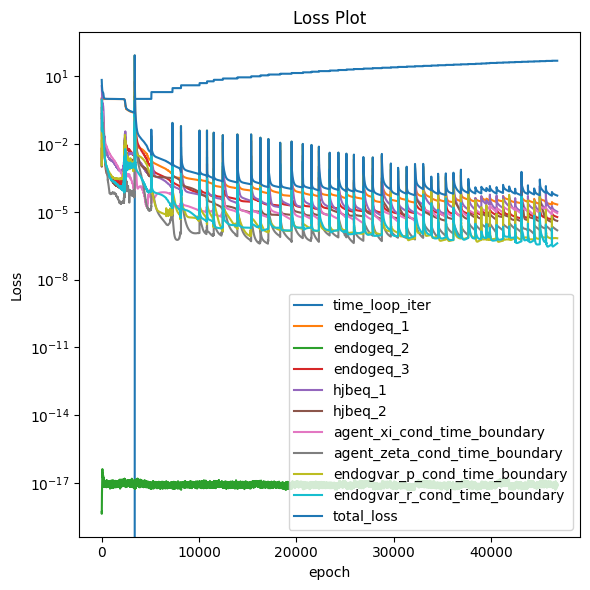

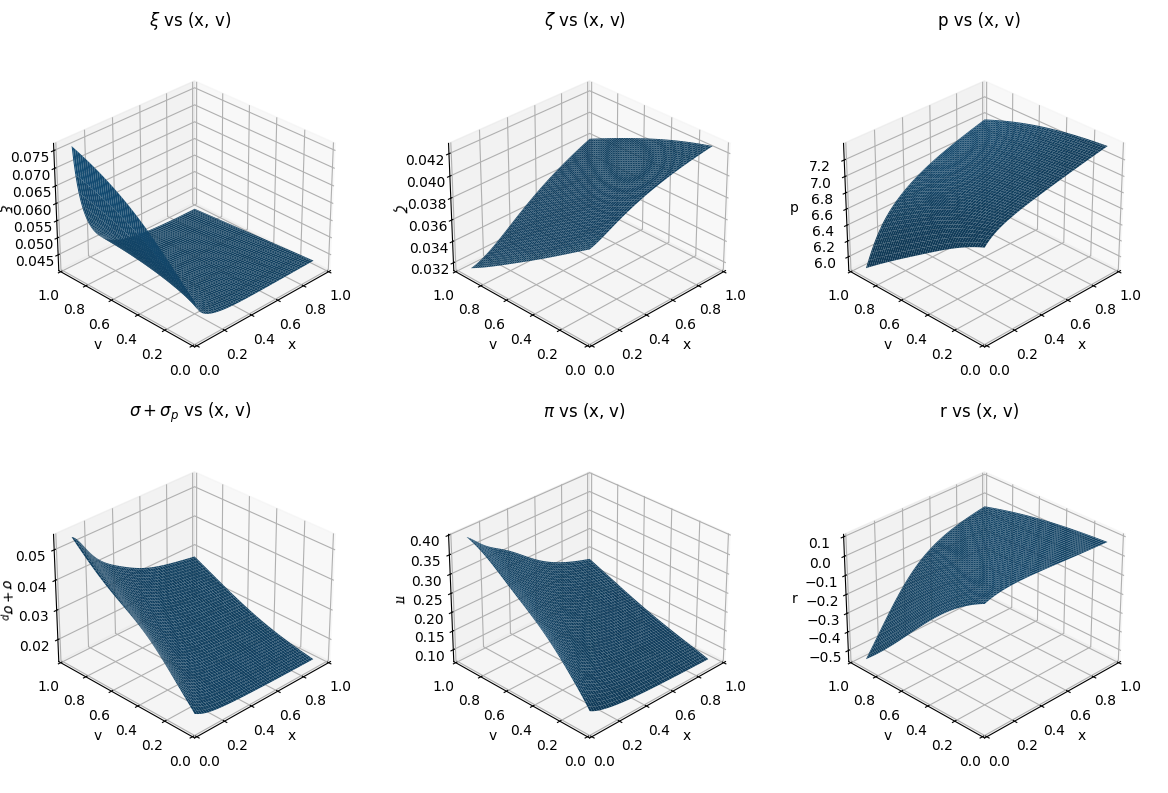

In [4]:
plot_loss_df(fn=f"{MODEL_DIR}/model_min_loss.csv", loss_plot_fn=f"{MODEL_DIR}/model_min_loss.png")
pde_model.plot_vars([r"$\xi$", r"$\zeta$", "p", 
                     r"$\sigma+\sigma_p = \sigma + \sigma_p$", r"$\pi$", "r"], ncols=3)

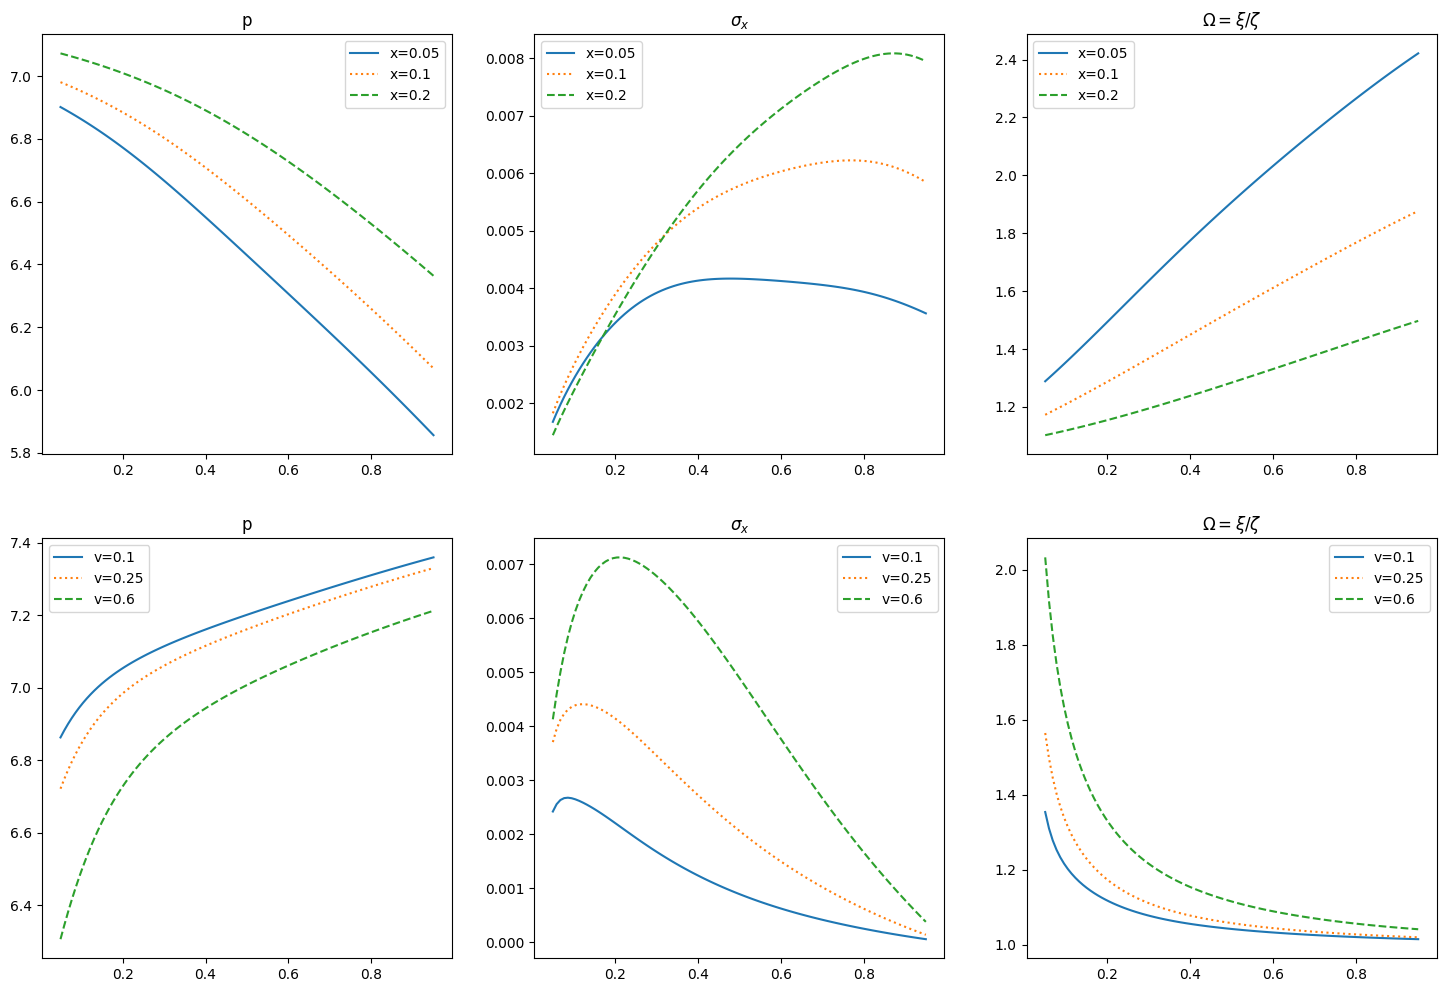

In [5]:
fig, ax = plt.subplots(2, 3, figsize=(18, 12))
for x_val, linestyle in [(0.05, "-"), (0.1, ":"), (0.2, "--")]:
    sv = torch.ones((100, 3), device=pde_model.device) * x_val
    sv[:, 1] = torch.linspace(0.05, 0.95, 100, device=pde_model.device)
    sv[:, 2] = torch.zeros((100,), device=pde_model.device)
    for i, sv_name in enumerate(pde_model.state_variables):
        pde_model.variable_val_dict[sv_name] = sv[:, i:i+1]
    pde_model.update_variables(sv)
    p = pde_model.variable_val_dict["p"]
    sigx = pde_model.variable_val_dict["sigx"]
    omega = pde_model.variable_val_dict["xi"] / pde_model.variable_val_dict["zeta"]
    ax[0][0].plot(sv[:, 1].detach().cpu().numpy(), p.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"x={x_val}")
    ax[0][1].plot(sv[:, 1].detach().cpu().numpy(), sigx.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"x={x_val}")
    ax[0][2].plot(sv[:, 1].detach().cpu().numpy(), omega.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"x={x_val}")
    ax[0][0].set_title(r"p")
    ax[0][1].set_title(r"$\sigma_x$")
    ax[0][2].set_title(r"$\Omega = \xi/\zeta$")
    ax[0][0].legend()
    ax[0][1].legend()
    ax[0][2].legend()

for v_val, linestyle in [(0.1, "-"), (0.25, ":"), (0.6, "--")]:
    sv = torch.ones((100, 3), device=pde_model.device) * v_val
    sv[:, 0] = torch.linspace(0.05, 0.95, 100, device=pde_model.device)
    sv[:, 2] = torch.zeros((100,), device=pde_model.device)
    for i, sv_name in enumerate(pde_model.state_variables):
        pde_model.variable_val_dict[sv_name] = sv[:, i:i+1]
    pde_model.update_variables(sv)
    p = pde_model.variable_val_dict["p"]
    sigx = pde_model.variable_val_dict["sigx"]
    omega = pde_model.variable_val_dict["xi"] / pde_model.variable_val_dict["zeta"]
    ax[1][0].plot(sv[:, 0].detach().cpu().numpy(), p.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"v={v_val}")
    ax[1][1].plot(sv[:, 0].detach().cpu().numpy(), sigx.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"v={v_val}")
    ax[1][2].plot(sv[:, 0].detach().cpu().numpy(), omega.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"v={v_val}")
    ax[1][0].set_title(r"p")
    ax[1][1].set_title(r"$\sigma_x$")
    ax[1][2].set_title(r"$\Omega = \xi/\zeta$")
    ax[1][0].legend()
    ax[1][1].legend()
    ax[1][2].legend()

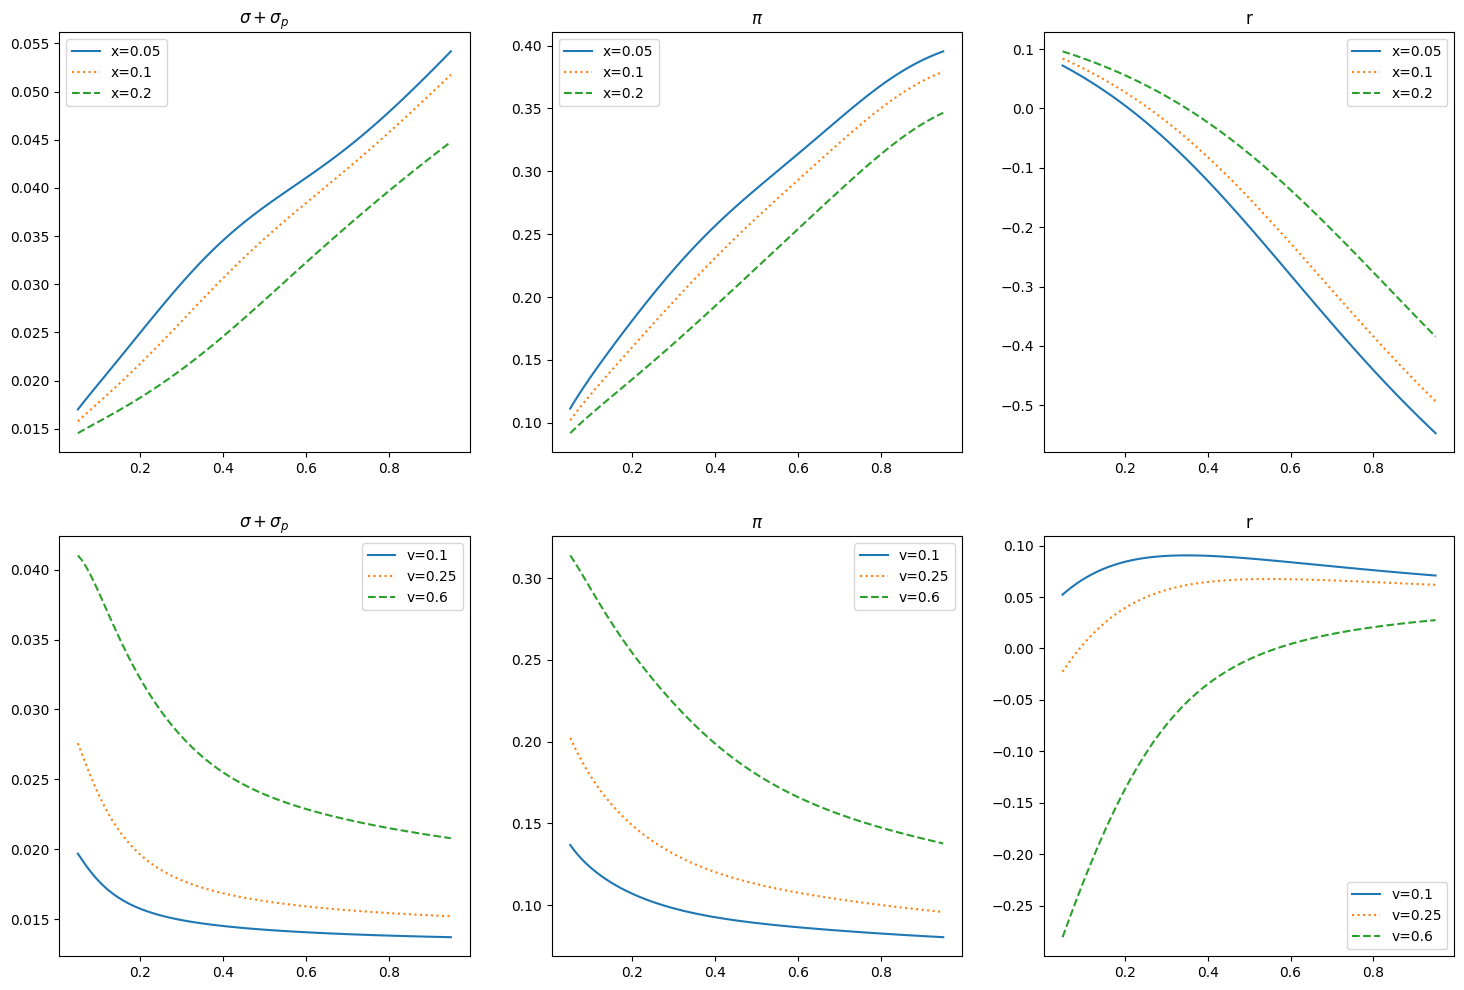

In [6]:
fig, ax = plt.subplots(2, 3, figsize=(18, 12))
for x_val, linestyle in [(0.05, "-"), (0.1, ":"), (0.2, "--")]:
    sv = torch.ones((100, 3), device=pde_model.device) * x_val
    sv[:, 1] = torch.linspace(0.05, 0.95, 100, device=pde_model.device)
    sv[:, 2] = torch.zeros((100,), device=pde_model.device)
    for i, sv_name in enumerate(pde_model.state_variables):
        pde_model.variable_val_dict[sv_name] = sv[:, i:i+1]
    pde_model.update_variables(sv)
    sigsigp = pde_model.variable_val_dict["sigma"] + pde_model.variable_val_dict["sigp"]
    pi = pde_model.variable_val_dict["signxi"]
    r = pde_model.variable_val_dict["r"]
    ax[0][0].plot(sv[:, 1].detach().cpu().numpy(), sigsigp.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"x={x_val}")
    ax[0][1].plot(sv[:, 1].detach().cpu().numpy(), pi.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"x={x_val}")
    ax[0][2].plot(sv[:, 1].detach().cpu().numpy(), r.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"x={x_val}")
    ax[0][0].set_title(r"$\sigma+\sigma_p$")
    ax[0][1].set_title(r"$\pi$")
    ax[0][2].set_title("r")
    ax[0][0].legend()
    ax[0][1].legend()
    ax[0][2].legend()
for v_val, linestyle in [(0.1, "-"), (0.25, ":"), (0.6, "--")]:
    sv = torch.ones((100, 3), device=pde_model.device) * v_val
    sv[:, 0] = torch.linspace(0.05, 0.95, 100, device=pde_model.device)
    sv[:, 2] = torch.zeros((100,), device=pde_model.device)
    for i, sv_name in enumerate(pde_model.state_variables):
        pde_model.variable_val_dict[sv_name] = sv[:, i:i+1]
    pde_model.update_variables(sv)
    sigsigp = pde_model.variable_val_dict["sigma"] + pde_model.variable_val_dict["sigp"]
    pi = pde_model.variable_val_dict["signxi"]
    r = pde_model.variable_val_dict["r"]
    ax[1][0].plot(sv[:, 0].detach().cpu().numpy(), sigsigp.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"v={v_val}")
    ax[1][1].plot(sv[:, 0].detach().cpu().numpy(), pi.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"v={v_val}")
    ax[1][2].plot(sv[:, 0].detach().cpu().numpy(), r.detach().cpu().numpy().reshape(-1), linestyle=linestyle, label=f"v={v_val}")
    ax[1][0].set_title(r"$\sigma+\sigma_p$")
    ax[1][1].set_title(r"$\pi$")
    ax[1][2].set_title("r")
    ax[1][0].legend()
    ax[1][1].legend()
    ax[1][2].legend()